## **Sentiment analysis using Glove embeddings and LSTM.**

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We download the pre-trained word embeddings.

In [9]:
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.6B.zip \
    -O /tmp/glove.6B.zip

--2021-05-20 08:48:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-20 08:48:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-20 08:48:46--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/t

Next we extract them into a temporary folder:

In [11]:
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

Loading the Dataset.

In [12]:
df = pd.read_json('/content/Amazon_Instant_Video_5.json', lines = True)
df.head()

reviewerID        asin  ... unixReviewTime   reviewTime
0  A11N155CW1UV02  B000H00VBQ  ...     1399075200   05 3, 2014
1  A3BC8O2KCL29V2  B000H00VBQ  ...     1346630400   09 3, 2012
2   A60D5HQFOTSOM  B000H00VBQ  ...     1381881600  10 16, 2013
3  A1RJPIGRSNX4PW  B000H00VBQ  ...     1383091200  10 30, 2013
4  A16XRPF40679KG  B000H00VBQ  ...     1234310400  02 11, 2009

[5 rows x 9 columns]

In [14]:
len(df)

37126

In [15]:
df = df.sample(n=10000)

In [16]:
len(df)

10000

In [17]:
df["textlength"] = df["reviewText"].apply(len)

In [18]:
df.describe()

overall  unixReviewTime    textlength
count  10000.00000    1.000000e+04  10000.000000
mean       4.20440    1.376869e+09    513.302200
std        1.12461    3.074979e+07    849.614422
min        1.00000    9.754560e+08      4.000000
25%        4.00000    1.367798e+09    146.000000
50%        5.00000    1.384819e+09    231.000000
75%        5.00000    1.394323e+09    480.000000
max        5.00000    1.406074e+09  13766.000000

In [19]:
df.head()

reviewerID        asin  ...   reviewTime textlength
19664  A2S6J50W5S6V5O  B00A2KIMH6  ...  03 22, 2013        342
7404   A1YUR0XD8GV30W  B004BGS3C6  ...  06 20, 2013        737
27365   AC900425G84IW  B00DQISQX6  ...  06 19, 2014        276
10986   AA91J3AZDZIIG  B005VA7M2I  ...  06 20, 2013        117
5459   A3UKLX2A9T589C  B003MAA5J6  ...   09 6, 2013        626

[5 rows x 10 columns]

In [20]:
df.tail()

reviewerID        asin  ...   reviewTime textlength
23523  A1IFQ9IMH1W92A  B00CBKUWKA  ...  04 18, 2013        136
687     AI8ZXQ2LY3OO3  B000MVN8HE  ...  05 12, 2014        742
36645  A2EO4O7D7BA2K8  B00KD9N9BA  ...  06 15, 2014       1628
4357   A24LOUMD2QFFZP  B002T33I64  ...  07 12, 2014         44
4017   A3B57IDRH62UU9  B002LS7YVM  ...   03 3, 2014        175

[5 rows x 10 columns]

In [21]:
df['reviewText']

19664    I have enjoyed getting to know the characters ...
7404     I have to admit that I am hooked by this witty...
27365    A TV series that entertains, educates and give...
10986    My husband and I started watching survivor out...
5459     The final season (YES...ONLY 3!!! WAKE UP BBC!...
                               ...                        
23523    Not sure how I feel about this...it's almost l...
687      Lots to chew on and enjoy whether you were alr...
36645    I think most people realize that when going in...
4357          It's Sesame Street what more is there to say
4017     My daughter really likes this show.  Lots of b...
Name: reviewText, Length: 10000, dtype: object

In [22]:
df = df[['reviewText', 'overall']]
df.head()

reviewText  overall
19664  I have enjoyed getting to know the characters ...        4
7404   I have to admit that I am hooked by this witty...        5
27365  A TV series that entertains, educates and give...        5
10986  My husband and I started watching survivor out...        4
5459   The final season (YES...ONLY 3!!! WAKE UP BBC!...        5

In [23]:
df['overall'] = [1 if overall > 2 else 0 
                            for overall in df['overall'].values]
df.head()

reviewText  overall
19664  I have enjoyed getting to know the characters ...        1
7404   I have to admit that I am hooked by this witty...        1
27365  A TV series that entertains, educates and give...        1
10986  My husband and I started watching survivor out...        1
5459   The final season (YES...ONLY 3!!! WAKE UP BBC!...        1

In [24]:
df.shape

(10000, 2)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 19664 to 4017
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  10000 non-null  object
 1   overall     10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 234.4+ KB


In [26]:
df['overall'].value_counts()

1    9014
0     986
Name: overall, dtype: int64

Spliting the data into train and test sets:

In [27]:
X = df['reviewText']
y = df['overall']

X_train_sentences, X_test_sentences, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

**Tokenizing the words.**

In [28]:
vocab_size = 5000
embedding_dim = 16
max_len = 100
trunction_type='post'
padding_type='post'
oov_token = "<OOV>"

In [29]:
tokenize = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenize.fit_on_texts(X_train_sentences)

The word index show us how words are mapped into numbers:

In [30]:
word_index = tokenize.word_index

`texts_to_sequences` convert the words into sequences so that a complete sequence of numbers can represent every sentence. 

In [31]:
X_train = tokenize.texts_to_sequences(X_train_sentences)
X_test = tokenize.texts_to_sequences(X_test_sentences)

In [34]:
X_train

[[10,
  1504,
  6,
  92,
  28,
  4153,
  1049,
  50,
  1,
  8,
  112,
  68,
  66,
  83,
  10,
  14,
  44,
  437,
  3,
  179,
  216,
  831,
  9,
  2,
  136,
  19,
  41,
  8,
  185,
  26,
  105,
  34],
 [10,
  16,
  7,
  144,
  5,
  59,
  13,
  2,
  338,
  167,
  2098,
  223,
  223,
  974,
  3739,
  85,
  145,
  415,
  5,
  25,
  71,
  2,
  334,
  154,
  178,
  1944,
  1,
  39,
  2,
  341,
  107,
  48,
  1,
  48,
  20,
  22,
  1742,
  5,
  70,
  72,
  1141,
  2450,
  4154,
  259,
  3381,
  170,
  1,
  6,
  1,
  145,
  5,
  154,
  4,
  48,
  1,
  2169,
  48,
  6,
  295,
  2451,
  39,
  4419,
  341,
  26,
  1058,
  4419,
  124,
  4155,
  188,
  2587,
  179,
  29,
  49,
  41,
  806,
  67,
  416,
  11],
 [49,
  467,
  71,
  303,
  11,
  487,
  3094,
  82,
  2,
  3932,
  240,
  32,
  17,
  2,
  1,
  6,
  1,
  18,
  1,
  1250,
  584,
  520,
  4,
  301,
  772,
  39,
  3543,
  2779,
  2,
  1,
  1,
  887,
  11,
  94,
  4,
  412,
  6,
  2371,
  11,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  548,
  1,
  

In [35]:
X_train[9:11]

[[2,
  360,
  7,
  53,
  32,
  14,
  51,
  53,
  32,
  157,
  109,
  6,
  2,
  157,
  20,
  98,
  5,
  66,
  15,
  26,
  206,
  4,
  32,
  549],
 [1,
  1,
  38,
  149,
  93,
  4,
  268,
  6,
  1997,
  260,
  292,
  5,
  24,
  143,
  1188,
  58,
  2,
  2374,
  354,
  39,
  1,
  19,
  149,
  37,
  2,
  1]]

Using `pad_sequences`function to make it uniform.

In [36]:
X_train_pad = pad_sequences(X_train,maxlen=max_len, padding=padding_type, 
                            truncating=trunction_type)

X_test_pad = pad_sequences(X_test,maxlen=max_len, padding=padding_type, 
                           truncating=trunction_type)

### **Glove Embedding**
We use pre-trained word embeddings to create own embedding layer.

In [37]:
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [39]:
num_words = len(word_index) + 1

embedding_matrix = np.zeros((num_words, max_len))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) 
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Finally we create the embedding layer:


In [40]:
embedding_layer = Embedding(num_words,
                            max_len,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

### **Build the model**
We create a model using embedding layer and Bidirectional LSTM layers. Bidirectional LSTMs are supported in Keras via the Bidirectional layer wrapper and it  takes a recurrent layer as an argument.

In [41]:
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(embedding_dim, return_sequences=True)), 
    Bidirectional(LSTM(embedding_dim)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2930800   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 32)           14976     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 2,952,253
Trainable params: 21,453
Non-trainable params: 2,930,800
_________________________________________________________________


Train the model for 5 epochs.

In [42]:
history = model.fit(X_train_pad, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_data=(X_test_pad, y_test),
                    verbose=1)

Epoch 1/5
250/250 [==============================] - 27s 82ms/step - loss: 0.3777 - accuracy: 0.9024 - val_loss: 0.3040 - val_accuracy: 0.9040
Epoch 2/5
250/250 [==============================] - 19s 76ms/step - loss: 0.2990 - accuracy: 0.9017 - val_loss: 0.2639 - val_accuracy: 0.9040
Epoch 3/5
250/250 [==============================] - 19s 76ms/step - loss: 0.2578 - accuracy: 0.9034 - val_loss: 0.2751 - val_accuracy: 0.9040
Epoch 4/5
250/250 [==============================] - 19s 75ms/step - loss: 0.2459 - accuracy: 0.9030 - val_loss: 0.2415 - val_accuracy: 0.9040
Epoch 5/5
250/250 [==============================] - 19s 77ms/step - loss: 0.2372 - accuracy: 0.8991 - val_loss: 0.2319 - val_accuracy: 0.9040


Predictions on a test set:

In [43]:
loss, accuracy = model.evaluate(X_test_pad,y_test)
print('Test accuracy :', accuracy)

63/63 [==============================] - 2s 24ms/step - loss: 0.2319 - accuracy: 0.9040
Test accuracy : 0.9039999842643738


In [44]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [54]:
model.save("glove_model")

INFO:tensorflow:Assets written to: glove_model/assets


INFO:tensorflow:Assets written to: glove_model/assets


Adding the dropout layer for decrease overfitting and  we increase number of epochs to 10.

In [46]:
model2 = Sequential([
    embedding_layer,
    Bidirectional(LSTM(64, return_sequences=True)), 
    Bidirectional(LSTM(32)),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model2.compile(loss='binary_crossentropy', 
               optimizer=optimizer,
               metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2930800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,057,553
Trainable params: 126,753
Non-trainable params: 2,930,800
______________________________________

In [47]:
callbacks = EarlyStopping(monitor = 'val_accuracy', 
                          mode = 'max', 
                          patience = 10,
                          verbose = 1)

In [48]:
history2 = model2.fit(X_train_pad, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test_pad, y_test),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
250/250 [==============================] - 45s 159ms/step - loss: 0.4732 - accuracy: 0.8882 - val_loss: 0.3254 - val_accuracy: 0.9040
Epoch 2/10
250/250 [==============================] - 38s 154ms/step - loss: 0.3767 - accuracy: 0.8997 - val_loss: 0.3134 - val_accuracy: 0.9040
Epoch 3/10
250/250 [==============================] - 39s 154ms/step - loss: 0.3481 - accuracy: 0.9051 - val_loss: 0.2902 - val_accuracy: 0.9040
Epoch 4/10
250/250 [==============================] - 39s 157ms/step - loss: 0.3267 - accuracy: 0.9053 - val_loss: 0.2678 - val_accuracy: 0.9040
Epoch 5/10
250/250 [==============================] - 40s 158ms/step - loss: 0.3218 - accuracy: 0.8988 - val_loss: 0.2685 - val_accuracy: 0.9040
Epoch 6/10
250/250 [==============================] - 40s 160ms/step - loss: 0.2974 - accuracy: 0.9024 - val_loss: 0.2484 - val_accuracy: 0.9040
Epoch 7/10
250/250 [==============================] - 40s 159ms/step - loss: 0.2911 - accuracy: 0.8988 - val_loss: 0.2813 - val_ac

Predictions:

In [49]:
loss, accuracy = model2.evaluate(X_test_pad,y_test)
print('Test accuracy :', accuracy)

63/63 [==============================] - 3s 46ms/step - loss: 0.2395 - accuracy: 0.9040
Test accuracy : 0.9039999842643738


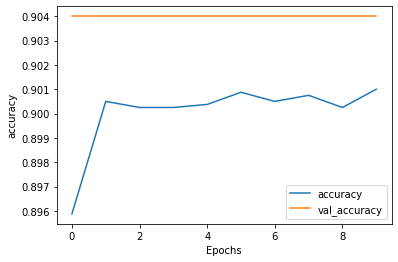

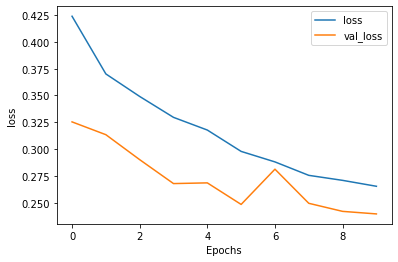

In [50]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")